# histograms
with Formula 1 data from https://ergast.com/mrd/db

In [1]:
%autosave 0
%load_ext autoreload
%autoreload 2

from tools import DATADIR, F1_ZIPPED
from etl.ergast import ErgastF1
from viz.plot import Plot

f1 = ErgastF1(F1_ZIPPED)
plot = Plot()
folder = DATADIR / 'plots'

Autosave disabled


In [2]:
pods = (
    f1.results.loc[lambda df: df['order'].le(3)]
    .join(f1.drivers['driver birthday'.split()], on='id_driver')
    .join(f1.races['date'], on='id_race')
    ['date order driver birthday'.split()]
)
pods['age'] = (pods['date'] - pods.pop('birthday')).dt.days / 365.25

# If co-drivers share a result, then keep the older one.    
pods = (
    pods.sort_values('date order age'.split())
    .drop_duplicates('date order'.split(), keep='last')
    .reset_index(drop=True)    
)
pods

,date,order,driver,age
0,1950-05-13,1,Nino Farina,43.534565
1,1950-05-13,2,Luigi Fagioli,51.923340
2,1950-05-13,3,Reg Parnell,38.863792
3,1950-05-21,1,Juan Fangio,38.907598
4,1950-05-21,2,Alberto Ascari,31.854894
...,...,...,...,...
3049,2019-11-17,2,Pierre Gasly,23.775496
3050,2019-11-17,3,Carlos Sainz,25.210130
3051,2019-12-01,1,Lewis Hamilton,34.896646
3052,2019-12-01,2,Max Verstappen,22.168378


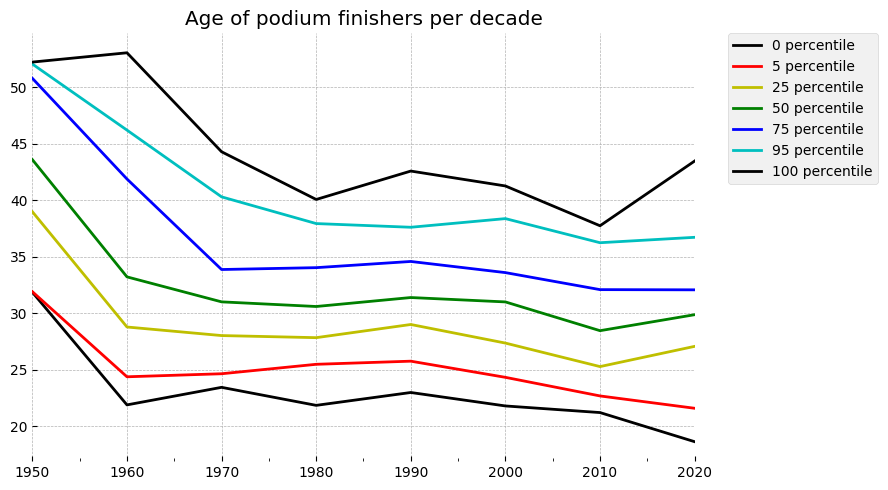

In [3]:
def podquants(**kwargs):
    data = pods.set_index('date')['age']    
    kwargs.setdefault('title', 'Age of podium finishers per decade')
    plot.quant(data, '10y', **kwargs)
    
podquants()

## all-ages shows

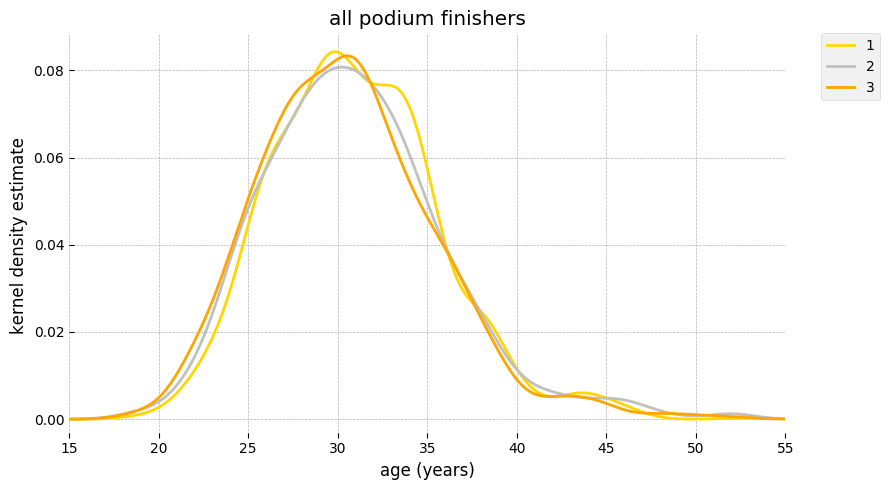

In [4]:
color = 'gold silver orange'.split()
limit = (15, 55)

def density(**kwargs):
    kwargs.setdefault('color', color)
    kwargs.setdefault('title', 'all podium finishers')
    kwargs.setdefault('xlim', limit)
    kwargs.setdefault('xlabel', 'age (years)')
    kwargs.setdefault('ylabel', 'kernel density estimate')
    
    data = pods.pivot(index='date', columns='order', values='age')
    
    return plot.density(data, **kwargs)
    
axes = density()
axes.figure.savefig(folder / 'all-ages_shows.png')

## good old boys

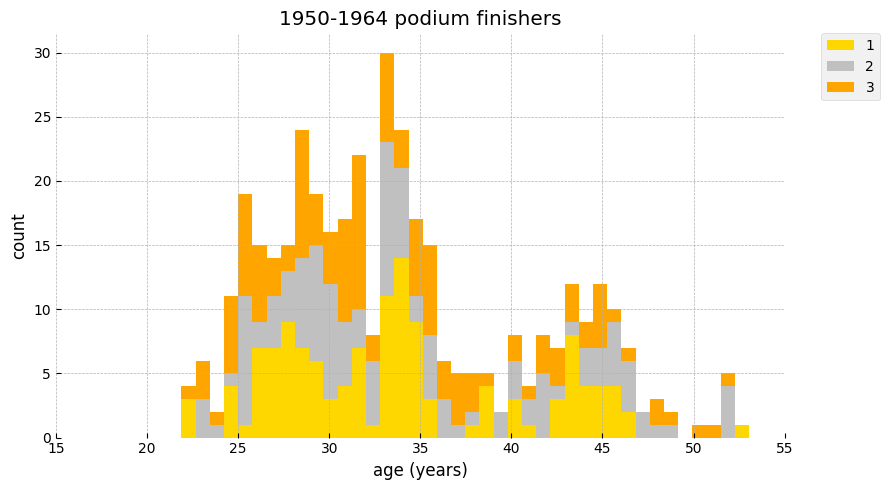

In [5]:
def podhist(start, stop, **kwargs):
    kwset = kwargs.setdefault
    kwset('bins', 40)
    kwset('color', color)
    kwset('title', f"{start}-{stop} podium finishers")
    kwset('xlim', limit)
    kwset('xlabel', 'age (years)')
    kwset('ylabel', 'count')

    data = pods.pivot(index='date', columns='order', values='age')
    data = data.loc[str(start) : str(stop)]
   
    return plot.hist(data, **kwargs)
    
axes = podhist(1950, 1964)
axes.figure.savefig(folder / 'good_old_boys.png')

## generation ickx

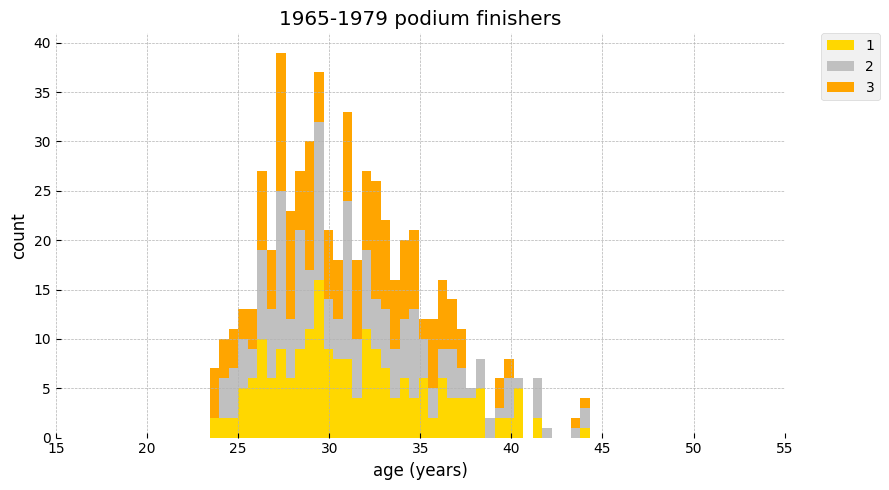

In [6]:
podhist(1965,1979).figure.savefig(folder / 'generation_ickx.png')

## da silva foxes

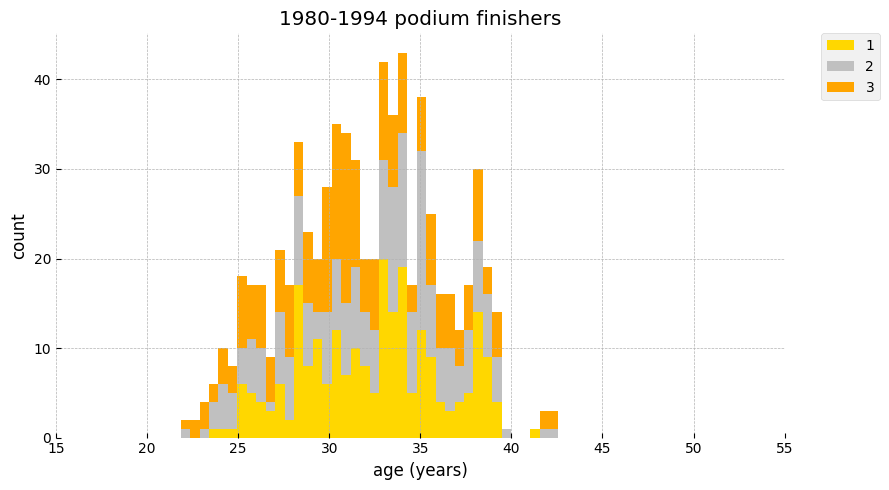

In [7]:
podhist(1980,1994).figure.savefig(folder / 'da_silva_foxes.png')

## centurions

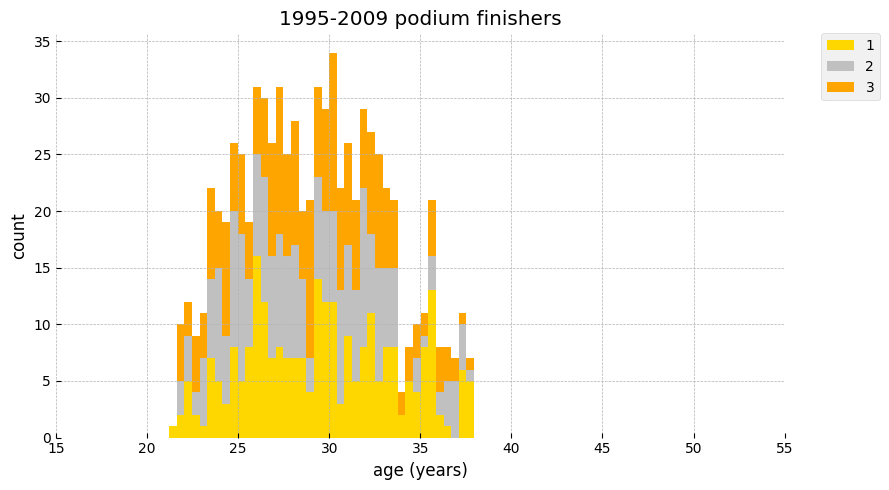

In [8]:
podhist(1995,2009).figure.savefig(folder / 'centurions.png')

## electric youth

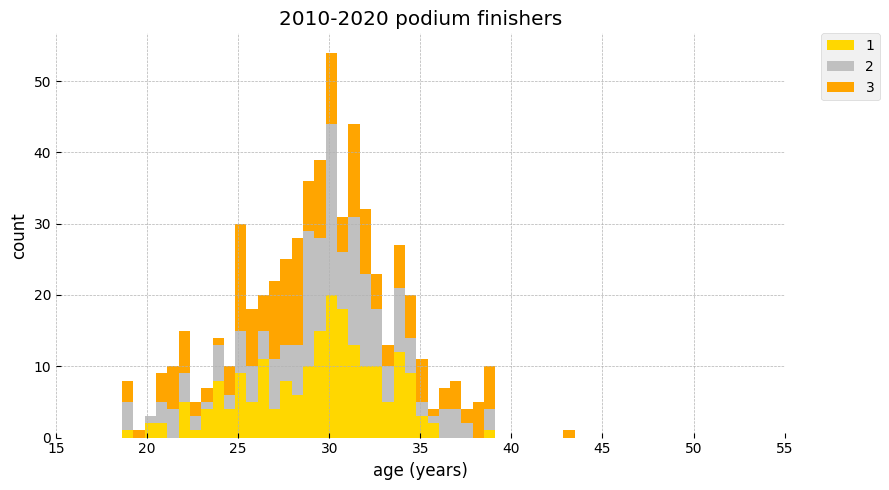

In [9]:
podhist(2010,2020).figure.savefig(folder / 'electric_youth.png')

## over the hills

In [10]:
olds = (
    pods.loc[pods.groupby('driver')['age'].idxmax()]
    .nlargest(10,'age').reset_index(drop=True)
    .sort_index(axis=1).round(3)
)
olds.index = range(1, 1 + len(olds))
olds.to_html(folder / 'oldest.html')
olds

,age,date,driver,order
1,53.057,1951-07-01,Luigi Fagioli,1
2,50.795,1950-05-21,Louis Chiron,3
3,49.996,1953-06-07,Felice Bonetto,3
4,48.914,1955-09-11,Piero Taruffi,2
5,48.597,1955-06-05,Nino Farina,3
6,46.209,1957-09-08,Juan Fangio,2
7,44.830,1955-07-16,Karl Kling,3
8,44.616,1950-06-18,Louis Rosier,3
9,44.329,1953-09-13,Luigi Villoresi,3
10,44.293,1970-07-18,Jack Brabham,2


In [11]:
utes = (
    pods.loc[pods.groupby('driver')['age'].idxmin()]
    .nsmallest(10, 'age').reset_index(drop=True)
    .sort_index(axis=1).round(3)
)
utes.index = range(1, 1 + len(utes))
utes.to_html(folder / 'youngest.html')
utes

,age,date,driver,order
1,18.623,2016-05-15,Max Verstappen,1
2,18.656,2017-06-25,Lance Stroll,3
3,21.202,2008-09-14,Sebastian Vettel,1
4,21.248,2015-07-26,Daniil Kvyat,2
5,21.443,2014-03-16,Kevin Magnussen,2
6,21.454,2019-03-31,Charles Leclerc,3
7,21.648,2003-03-23,Fernando Alonso,3
8,21.758,2006-09-10,Robert Kubica,3
9,21.788,1997-04-13,Ralf Schumacher,3
10,21.840,1980-01-27,Elio de Angelis,2


In [12]:
hills = (
    pods.loc[pods['driver'].str.endswith('Hill')]
    .sort_values('age').drop_duplicates('driver', keep='last')
    .sort_values('age', ascending=False).round(3)
    .reset_index(drop=True).sort_index(axis=1)
)
hills.index += 1
hills.to_html(folder / 'hills.html')
hills

,age,date,driver,order
1,40.252,1969-05-18,Graham Hill,1
2,37.949,1998-08-30,Damon Hill,1
3,35.159,1962-06-17,Phil Hill,3
